In [78]:
import numpy as np
import pandas as pd
import joblib

from importlib import reload
from glob import glob
import os
import sys
import shutil
import model_pedestal as pedestal
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

sys.path.append("..")
import kiwi_operators as kwo
import config
import data_environment as env

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

reload(kwo)
reload(config)
reload(env)

feat_path_lst = glob(f"{config.dir_selected_feat}/data/*.pkl")
feat_num = len(feat_path_lst)



In [24]:
def calc_corr(input_x, input_y):
    tens_x = input_x
    tens_y = input_y

    sum_x = tf.reduce_sum(tens_x)
    sum_y = tf.reduce_sum(tens_y)

    tens_xx = tens_x * tens_x
    tens_yy = tens_y * tens_y
    tens_xy = tens_x * tens_y
    sum_xx = tf.reduce_sum(tens_xx)
    sum_xy = tf.reduce_sum(tens_xy)
    sum_yy = tf.reduce_sum(tens_yy)

    length = tf.cast(tf.squeeze(tf.shape(tens_x)), tf.float32)
    upper = sum_xy - sum_x * sum_y / length
    lower_x = tf.sqrt(sum_xx - sum_x * sum_x / length)
    lower_y = tf.sqrt(sum_yy - sum_y * sum_y / length)

    return upper / (lower_x * lower_y)


def ic(y_true, y_pred):
    tens_true = tf.squeeze(y_true)
    tens_pred = tf.squeeze(y_pred)
    return calc_corr(tens_true, tens_pred)


def get_model():
    inputs = keras.Input((feat_num,), dtype=tf.uint16)

    # cur_node = layers.Dense(8)(inputs)
    # cur_node = layers.Dropout(0.2)(cur_node)
    # cur_node = layers.Dense(8)(cur_node)
    # cur_node = layers.Dropout(0.2)(cur_node)
    # cur_node = layers.Dense(8)(cur_node)
    # cur_node = layers.Dropout(0.2)(cur_node)

    # outputs = layers.Dense(1)(cur_node)
    outputs = layers.Dense(1)(inputs)
    res_model = keras.Model(inputs=inputs, outputs=outputs)
    res_model.compile(optimizer=optimizers.Adam(0.001), loss="mse", metrics=ic)
    return res_model


class ModelPlainDnn(object):
    def __init__(self):
        self.model = get_model()

    def train(self, train_date_beg: int, train_date_end: int, verbose: bool = False):
        train_data = pedestal.prep_feat_target(train_date_beg, train_date_end)
        train_data = train_data.dropna()

        feat_cols = list(train_data.columns)
        feat_cols.remove("time")
        feat_cols.remove("investment")
        feat_cols.remove("target")
        x_train = np.array(train_data[feat_cols])
        y_train = np.array(train_data["target"])

        self.model.fit(x_train, y_train, epochs=300, shuffle=True, batch_size=1024)

    def save_model(self, file_path: str = f"{config.dir_model}/xgb.pkl"):
        joblib.dump(self.model, file_path)

    def predict(self, x_data: np.array):
        return self.model.predict(x_data)


In [88]:
from tensorflow.python.ops import math_ops


def ic(y_true, y_pred):
    tens_true = tf.squeeze(y_true)
    tens_pred = tf.squeeze(y_pred)
    return calc_corr(tens_true, tens_pred)


def ic_loss(x, y, axis=-2):
    """Loss function that maximizes the pearson correlation coefficient between the predicted values and the labels,
    while trying to have the same mean and variance"""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xsqsum = tf.reduce_sum(tf.math.squared_difference(x, xmean), axis=axis)
    ysqsum = tf.reduce_sum(tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum((x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xsqsum * ysqsum)
    return tf.convert_to_tensor(
        keras.backend.mean(tf.constant(1.0, dtype=x.dtype) - corr), dtype=tf.float32
    )


def get_model():
    inputs = keras.Input((feat_num,), dtype=tf.float64)
    # cur_node=layers.BatchNormalization()(inputs)

    cur_node = layers.Dense(
        3, activation="swish", kernel_regularizer=keras.regularizers.l2(1e-5)
    )(inputs)
    # cur_node = layers.Dropout(0.3)(cur_node)
    # cur_node = layers.Dense(8, activation="swish")(cur_node)
    # cur_node = layers.Dropout(0.5)(cur_node)

    outputs = layers.Dense(1)(cur_node)
    res_model = keras.Model(inputs=inputs, outputs=outputs)
    res_model.compile(optimizer=optimizers.Adam(0.001), loss=ic_loss, metrics=ic)
    return res_model


train_date_beg = 20160101
train_date_end = 20180101
train_data = pedestal.prep_feat_target(train_date_beg, train_date_end).dropna()
feat_cols = list(train_data.columns)
feat_cols.remove("time")
feat_cols.remove("investment")
feat_cols.remove("target")
x_train = train_data[feat_cols]
x_train = np.array(x_train)
y_train = np.array(train_data["target"])

valid_date_beg = 20180101
valid_date_end = 20190101
valid_data = pedestal.prep_feat_target(valid_date_beg, valid_date_end).dropna()
feat_cols = list(valid_data.columns)
feat_cols.remove("time")
feat_cols.remove("investment")
feat_cols.remove("target")
x_valid = valid_data[feat_cols]
x_valid = np.array(x_valid)
y_valid = np.array(valid_data["target"])

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

model = get_model()
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    shuffle=True,
    batch_size=512,
    validation_data=(x_valid, y_valid),
)


Epoch 1/50
37/37 [==============================] - 1s 10ms/step - loss: 1.0787 - ic: -0.0787 - val_loss: 0.9852 - val_ic: -0.0036
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 1.0682 - ic: -0.0681 - val_loss: 0.9818 - val_ic: -7.5320e-05
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 1.0553 - ic: -0.0553 - val_loss: 0.9793 - val_ic: 0.0035
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 1.0344 - ic: -0.0343 - val_loss: 0.9775 - val_ic: 0.0068
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 1.0003 - ic: -2.8770e-04 - val_loss: 0.9766 - val_ic: 0.0097
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 1.0006 - ic: -5.1826e-04 - val_loss: 0.9762 - val_ic: 0.0118
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.9789 - ic: 0.0212 - val_loss: 0.9762 - val_ic: 0.0133
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.9740 - ic

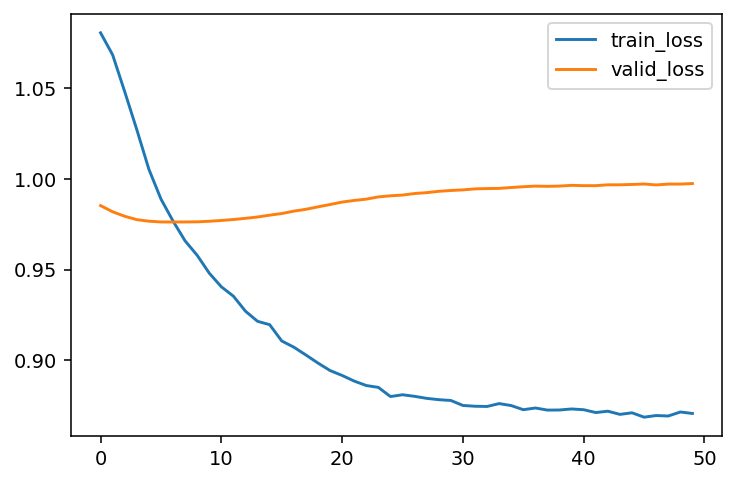

<Figure size 864x576 with 0 Axes>

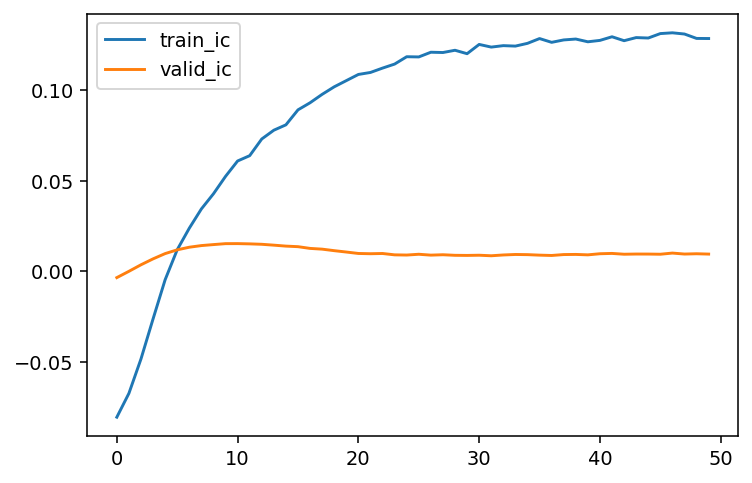

In [91]:
def plot_history(history):
    train_loss = history.history["loss"]
    valid_loss = history.history["val_loss"]
    train_ic = history.history["ic"]
    valid_ic = history.history["val_ic"]

    df_loss = pd.DataFrame([train_loss, valid_loss]).transpose()
    df_loss.columns = ["train_loss", "valid_loss"]
    df_ic = pd.DataFrame([train_ic, valid_ic]).transpose()
    df_ic.columns = ["train_ic", "valid_ic"]

    plt.rcParams["figure.dpi"] = 144
    df_loss.plot()
    plt.show()

    plt.figure(dpi=144)
    df_ic.plot()
    plt.show()


plot_history(history)


In [55]:
x_train.shape

(18723, 6)